<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving hokusai.jpg to hokusai.jpg

Upload Style Image


Saving starry.jpg to starry.jpg
Content Path: <_io.BytesIO object at 0x7fa34359ab30>
Style Path: <_io.BytesIO object at 0x7fa3427167d0>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


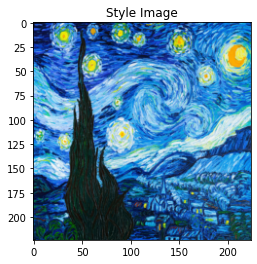

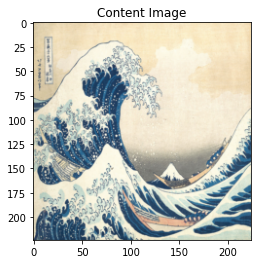

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
# Style layers, 
layers = [0,5,10,17,24]
#layers = [2, 7, 14, 21, 28]


# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
content_model = VGGIntermediate(layers)
content_model = content_model.cuda()
content_layers = content_model(content_image.cuda())

style_model = VGGIntermediate(layers)
style_model = style_model.cuda()
style_layers = style_model(style_image.cuda())

# Cache the outputs of the content and style layers for their respective images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

___

### Part 2
Create a classes for the style and content loss

**TODO:**


**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

In [10]:
def gram_matrix(generation_layers, style_layers):
  b, c, h, w = generation_layers.shape

  G = generation_layers.view(c, h*w).mm(generation_layers.view(c,h*w).t())
  A_style = style_layers.view(c, h*w)
  A_trans = style_layers.view(c,h*w).t()
  A = A_style.mm(A_trans)
  
  return G, A

class ContentLoss(nn.Module):
  def __init__(self):
    super(ContentLoss, self).__init__()
    
  def forward(self, gen_layer, content_layer):

    content_loss = 0
   
    content_loss += 1/5*torch.mean((gen_layer - content_layer)**2)
    
    return content_loss
    
class StyleLoss(nn.Module):
  def __init__(self):
    super(StyleLoss, self).__init__()
    
  def forward(self, gen_layer, style_layer):
    style_loss = 0
    G, A = gram_matrix(gen_layer, style_layer)
    style_loss += (1/5)*torch.mean((G-A)**2)
    
    return style_loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**
* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!


In [11]:
# Start with a copy of the content image
generated = content_image.clone().requires_grad_(True)

steps = 401
lr = .1
optimizer = optim.Adam([generated], lr=lr)

generation_model = VGGIntermediate(layers)
generation_model = generation_model.cuda()


get_content_loss = ContentLoss()
get_style_loss = StyleLoss()

alpha = 1
beta = 1e-4
# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
for step in range(steps):

  with torch.no_grad():
    torch.clamp(generated,0,1)
  
  generation_layers = generation_model(generated)
  
  content_loss = 0
  style_loss = 0
  total_loss = None

  for index in layers:
    content_loss += get_content_loss(generation_layers[index], content_layers[index])
    style_loss += get_style_loss(generation_layers[index], style_layers[index])
  
  if step % 50 == 0:
    print("Content Loss at " + str(step) + "th step: " + str(content_loss))
    print("Style Loss at " + str(step) + "th step: " + str(style_loss))
  
  total_loss = alpha*content_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward(retain_graph=True)
  optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Content Loss at 0th step: tensor(0., device='cuda:0', grad_fn=<AddBackward0>)
Style Loss at 0th step: tensor(7.0769e+09, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss at 50th step: tensor(76.2529, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss at 50th step: tensor(2.2566e+08, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss at 100th step: tensor(81.9804, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss at 100th step: tensor(1.0213e+08, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss at 150th step: tensor(83.5003, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss at 150th step: tensor(66039944., device='cuda:0', grad_fn=<AddBackward0>)
Content Loss at 200th step: tensor(84.7780, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss at 200th step: tensor(46836624., device='cuda:0', grad_fn=<AddBackward0>)
Content Loss at 250th step: tensor(85.5964, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss at 250th step: tensor(35418024., device='cuda:0', grad_fn=<Add

In [12]:
from torchvision.utils import save_image
from IPython.display import Image

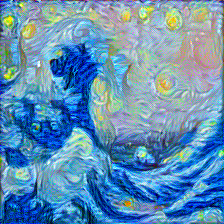

In [13]:
# Show the image
save_image(generated, "output.png")
Image("output.png")

### Part 4

**TODO:**

**DONE:**
- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

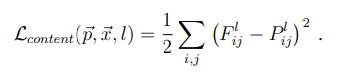

Equation (1) p.10: 
* L<sub>content</sub> is the "Content Loss" between the content image and the generated image 
* p-bar is the original content image and x-bar is our generated
* l is the layer of p-bar and x-bar that is being represented.
* i is the filter currently being looked at within layer l.
* j is the position within layer l that filter i is found.
* sigma i,j is the sum of all activations for all filters i in all positions j within each layer l of the content image and the generated image.
* F<sup>l</sup><sub>i,j</sub> is the activation for layer l, filter i, position j of the generated image.
* P<sup>l</sup><sub>i,j</sub> is the activation for layer l, filter i, position j of the original content image.

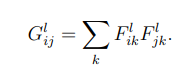

Equation (2) p.11:

* G<sup>l</sup><sub>ij</sub> is the resulting Gram Matrix, sub scripts i and j represent the two feature maps that make up the product G<sub>ij</sub>. l is the layer from which the feature maps come from.
* Sigma k is the representation of taking the dot product of the two feature maps for the current channel, the sum of which makes up a value in the CxC sized resulting Gram Matrix
* F<sup>l</sup><sub>ik</sub> is the first feature map i for layer l and the current position k in the channel that is associated with the matching position k of the second feature map.
* F<sup>l</sup><sub>jk</sub> is the second feature map j (transposed version of i) for layer l at position k in the dot product of the two which makes up a value in the CxC Gram Matrix.


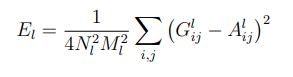


Equation (4) p. 11:

* E<sub>l</sub> is the contribution of that specific layer to the total style loss.
* G<sup>l</sup><sub>ij</sub> is the gram matrix of the generated image for this layer l for feature maps i and j
* A<sup>l</sup><sub>ij</sub> is the same gram matrix for layer l but for the style image at all feature maps i and j
* The equation is squared because it is the Means Squared Error of the Generated Gram Matrix and the Style Gram Matrix.
* Sigma i,j is adding the Means Squared Distance of the two Gram Matricies for all feature maps i and j
* N<sup>2</sup><sub>l</sub> and M<sup>2</sup><sub>l</sub> are constants attached to the means squared error to adjust how muche each layer contributes to the total style loss.

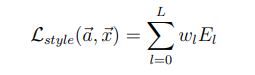

Equation (5) p. 11:
* L<sub>style</sub> is the total style loss
* a-bar is the original style image and x-bar is the generated output image.
* Sigma l=0 to L means to sum the loss generated by each layer l for all layers L to get the total style loss.
* E<sub>l</sub> means the style loss generated by one layer l.
* w<sub>l</sub> is an hyper-parameter of weight assigned to each layer l in determining how much each layer contributes to the total style loss. It can be adjusted to weigh high layer more greatly, but typically can be 1/|L| so each layer is weighted equally.